In [ ]:
import tensorflow as tf
import numpy as np
import pathlib
import datetime

# printout versions
print(f"Tensor Flow Version: {tf.__version__}")
print(f"numpy Version: {np.version.version}")

Tensor Flow Version: 2.8.2
numpy Version: 1.21.6


In [ ]:
%load_ext tensorboard

In [ ]:
from keras.utils.np_utils import to_categorical

In [ ]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from tensorflow.keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

In [ ]:
luna_cancer_data = np.load('/content/drive/MyDrive/Ramasubramanya/LotusFeet/cancernodule_image_900_96_96_patches.npy')
luna_cancer_data = luna_cancer_data[:850]
print(luna_cancer_data.shape, luna_cancer_data[0].shape)

(850, 96, 96, 1) (96, 96, 1)


In [ ]:
luna_cancer_data = luna_cancer_data.reshape(850,96,96)
luna_cancer_data_rgb = np.repeat(luna_cancer_data[..., np.newaxis], 3, -1)
print(luna_cancer_data_rgb.shape, luna_cancer_data_rgb[0].shape)

(850, 96, 96, 3) (96, 96, 3)


In [ ]:
luna_non_cancer_data = np.load("/content/drive/MyDrive/Ramasubramanya/LotusFeet/non_cancernodule_image_1400_96_96_patches.npy")
luna_non_cancer_data = luna_non_cancer_data[:850]
print(luna_non_cancer_data.shape, luna_non_cancer_data[0].shape)

(850, 96, 96, 1) (96, 96, 1)


In [ ]:
luna_non_cancer_data = luna_non_cancer_data.reshape(850,96,96)
luna_non_cancer_data_rgb = np.repeat(luna_non_cancer_data[..., np.newaxis], 3, -1)
print(luna_non_cancer_data_rgb.shape, luna_non_cancer_data_rgb[0].shape)

(850, 96, 96, 3) (96, 96, 3)


In [ ]:
X_luna = np.concatenate((luna_cancer_data_rgb,luna_non_cancer_data_rgb), axis = 0)
print(X_luna.shape, X_luna[0].shape)

(1700, 96, 96, 3) (96, 96, 3)


In [ ]:
cancer_labels = np.ones(850)
noncancer_labels = np.zeros(850)
Y_luna = np.concatenate((cancer_labels,noncancer_labels), axis = 0)

In [ ]:
print(X_luna.shape, Y_luna.shape)

(1700, 96, 96, 3) (1700,)


In [ ]:
from sklearn.model_selection import train_test_split
(X_luna_train, X_luna_test, y_luna_train, y_luna_test) = train_test_split(X_luna, Y_luna,test_size=0.3, stratify=Y_luna, random_state=42)

In [ ]:
print((X_luna_train.shape, X_luna_test.shape, y_luna_train.shape, y_luna_test.shape))

((1190, 96, 96, 3), (510, 96, 96, 3), (1190,), (510,))


In [ ]:
y_luna_train = to_categorical(y_luna_train, num_classes= 2)
y_luna_test = to_categorical(y_luna_test, num_classes= 2)
print(y_luna_train.shape,y_luna_test.shape)

(1190, 2) (510, 2)


In [ ]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='categorical_crossentropy',#loss='binary_crossentropy', #
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [ ]:
K.clear_session()
gc.collect()

resnet = tf.keras.applications.InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(96,96,3)
)


 
#building RESNET Model

inception_model = build_model(resnet ,lr = 1e-4)
inception_model.summary()

87924736/87910968 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization_94 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
def train_model1():
  
  # model = create_model()
  inception_model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  logdir = os.path.join("logs", "inception_model",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  inception_model.fit(x=X_luna_train, 
            y=y_luna_train, 
            epochs=20, 
            validation_data=(X_luna_test, y_luna_test), 
            callbacks=[tensorboard_callback])

train_model1()

Epoch 1/20
38/38 [==============================] - 29s 252ms/step - loss: 0.6966 - accuracy: 0.6924 - val_loss: 32.8889 - val_accuracy: 0.5000
Epoch 2/20
38/38 [==============================] - 6s 156ms/step - loss: 0.3354 - accuracy: 0.8874 - val_loss: 2.9207 - val_accuracy: 0.5863
Epoch 3/20
38/38 [==============================] - 6s 157ms/step - loss: 0.2503 - accuracy: 0.9101 - val_loss: 3.1579 - val_accuracy: 0.5333
Epoch 4/20
38/38 [==============================] - 6s 158ms/step - loss: 0.1751 - accuracy: 0.9445 - val_loss: 0.7369 - val_accuracy: 0.5000
Epoch 5/20
38/38 [==============================] - 6s 157ms/step - loss: 0.2450 - accuracy: 0.9227 - val_loss: 17.9232 - val_accuracy: 0.5373
Epoch 6/20
38/38 [==============================] - 6s 158ms/step - loss: 0.3400 - accuracy: 0.8857 - val_loss: 53.2247 - val_accuracy: 0.4667
Epoch 7/20
38/38 [==============================] - 6s 158ms/step - loss: 0.2908 - accuracy: 0.9092 - val_loss: 8233.7402 - val_accuracy: 0.5000

In [ ]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.1 MB 16.7 MB/s 
     |████████████████████████████████| 84 kB 3.6 MB/s 
     |████████████████████████████████| 54 kB 3.2 MB/s 
     |████████████████████████████████| 212 kB 68.4 MB/s 
     |████████████████████████████████| 140 kB 80.9 MB/s 
     |████████████████████████████████| 84 kB 3.7 MB/s 
     |████████████████████████████████| 2.3 MB 67.1 MB/s 
     |████████████████████████████████| 272 kB 82.7 MB/s 
     |████████████████████████████████| 57 kB 5.8 MB/s 
     |████████████████████████████████| 1.1 MB 72.6 MB/s 
     |████████████████████████████████| 94 kB 3.9 MB/s 
     |████████████████████████████████| 271 kB 57.0 MB/s 
     |████████████████████████████████| 144 kB 67.6 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 80 kB 10.0 MB/s 
     |████████████████████████████████| 68 k

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import PIL
import pathlib

In [ ]:
cancer_classes = [0,1]

In [ ]:
print(cancer_classes)

[0, 1]


In [ ]:
cancer_classes = to_categorical(cancer_classes, num_classes= 2)

In [ ]:
print(cancer_classes)

[[1. 0.]
 [0. 1.]]


In [ ]:
print(cancer_classes[0][0])

1.0


In [ ]:
dataset_classes = 2

In [ ]:
import gradio as gr

In [ ]:
image = gr.inputs.Image(shape=(96,96))

/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)


In [ ]:
label = gr.outputs.Label(num_top_classes=2)

/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


In [ ]:
def predict_input_image(img):
  img_4d=img.reshape(-1,96,96,3)
  print(img.shape, img_4d.shape)
  #img_4d=img
  prediction=inception_model.predict(img_4d)[0]
  return {(cancer_classes[0][i]): float(prediction[i]) for i in range(2)}

In [ ]:
gr.Interface(fn=predict_input_image, inputs=image, outputs=label).launch(debug='True')

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://48022.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/fastapi/encoders.py", line 137, in jsonable_encoder
    data = dict(obj)
TypeError: 'numpy.float32' object is not iterable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/fastapi/encoders.py", line 141, in jsonable_encoder
    data = vars(obj)
TypeError: vars() argument must have __dict__ attribute

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(self.scope, self.receive, self.send)
  File "/usr/local/lib/python3.7/dist-packages/uvicorn/middleware/proxy_headers.py", line 78, in __call__
    return await self.app(scope, receive, send)
  File "/usr/local/lib/python3.7/dist-packages/fa

(96, 96, 3) (1, 96, 96, 3)
Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x7fcb92f40910>,
 'http://127.0.0.1:7860/',
 'https://48022.gradio.app')

In [ ]:
inception_model.save("/content/drive/MyDrive/Ramasubramanya/inception_model_tdy.h5")

In [ ]:
def train_model1():
  
  # model = create_model()
  inception_model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  logdir = os.path.join("logs", "inception_model",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  inception_model.fit(x=X_luna_train, 
            y=y_luna_train, 
            epochs=15, 
            validation_data=(X_luna_test, y_luna_test), 
            callbacks=[tensorboard_callback])

train_model1()

Epoch 1/15
38/38 [==============================] - 31s 256ms/step - loss: 0.7599 - accuracy: 0.6924 - val_loss: 281.7643 - val_accuracy: 0.5000
Epoch 2/15
38/38 [==============================] - 6s 159ms/step - loss: 0.3136 - accuracy: 0.8773 - val_loss: 10574.1855 - val_accuracy: 0.5000
Epoch 3/15
38/38 [==============================] - 6s 159ms/step - loss: 0.1809 - accuracy: 0.9336 - val_loss: 119.5041 - val_accuracy: 0.5020
Epoch 4/15
38/38 [==============================] - 6s 158ms/step - loss: 0.0798 - accuracy: 0.9739 - val_loss: 1.0622 - val_accuracy: 0.5549
Epoch 5/15
38/38 [==============================] - 6s 157ms/step - loss: 0.0415 - accuracy: 0.9857 - val_loss: 0.3462 - val_accuracy: 0.8137
Epoch 6/15
38/38 [==============================] - 6s 160ms/step - loss: 0.0254 - accuracy: 0.9950 - val_loss: 0.3112 - val_accuracy: 0.8529
Epoch 7/15
38/38 [==============================] - 6s 162ms/step - loss: 0.0373 - accuracy: 0.9882 - val_loss: 0.2872 - val_accuracy: 0.85

In [ ]:
# extract the predicted probabilities
p_pred_train = inception_model.predict(X_luna_train)

In [ ]:
y_pred_train = np.where(p_pred_train > 0.5, 1, 0)
print(y_pred_train)

[[1 0]
 [0 1]
 [1 0]
 ...
 [1 0]
 [1 0]
 [0 1]]


In [ ]:
y_luna_train = to_categorical(y_luna_train, num_classes= 2)

In [ ]:
type(y_luna_train)

numpy.ndarray

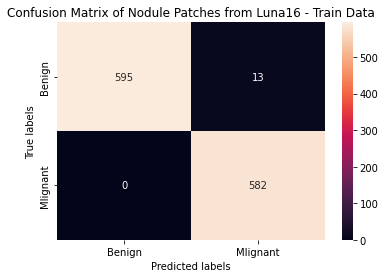

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['Benign','Mlignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred_train).argmax(axis=1), np.asarray(y_luna_train).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of Nodule Patches from Luna16 - Train Data'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

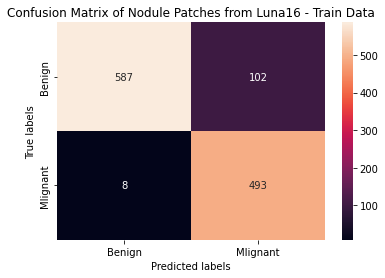

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['Benign','Mlignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred_train).argmax(axis=1), np.asarray(y_luna_train).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of Nodule Patches from Luna16 - Train Data'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

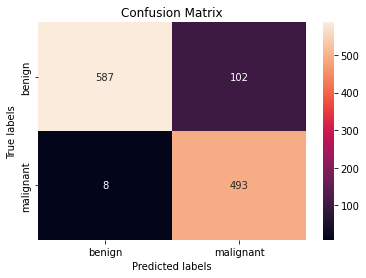

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred_train).argmax(axis=1), np.asarray(y_luna_train).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

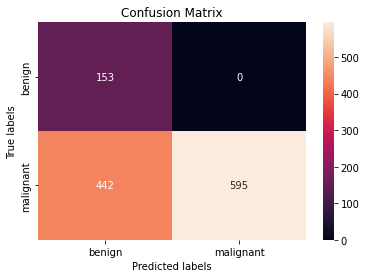

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred_train).argmax(axis=1), np.asarray(y_luna_train).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

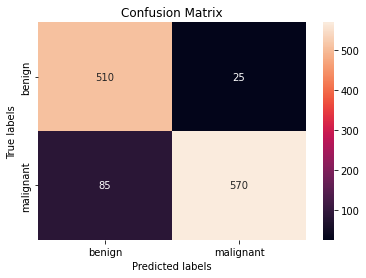

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred_train).argmax(axis=1), np.asarray(y_luna_train).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

In [ ]:
# extract the predicted probabilities
p_pred_test = inception_model.predict(X_luna_test)

In [ ]:
y_pred_test = np.where(p_pred_test > 0.5, 1, 0)
print(y_pred_test)

[[0 1]
 [1 0]
 [0 1]
 ...
 [0 1]
 [0 1]
 [1 0]]


In [ ]:
y_luna_test = to_categorical(y_luna_test, num_classes= 2)

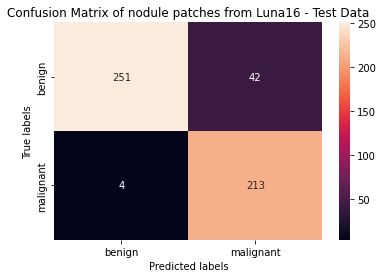

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred_test).argmax(axis=1), np.asarray(y_luna_test).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of nodule patches from Luna16 - Test Data'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

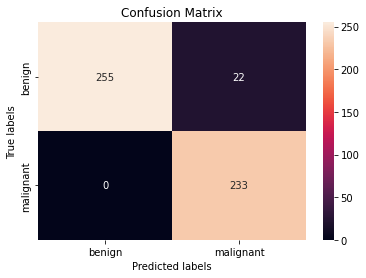

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred_test).argmax(axis=1), np.asarray(y_luna_test).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

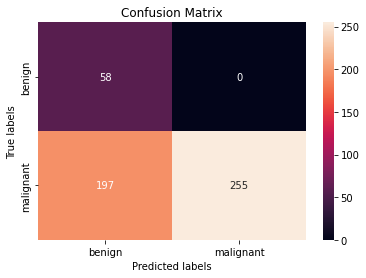

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred_test).argmax(axis=1), np.asarray(y_luna_test).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

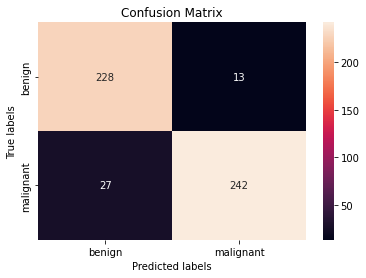

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred_test).argmax(axis=1), np.asarray(y_luna_test).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of nodule patches from Luna16 - Test Data'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

In [ ]:
luna_cancer_data = np.load('/content/drive/MyDrive/Ramasubramanya/LotusFeet/cancernodule_image_900_96_96_patches.npy')
testing_luna_cancer_data = luna_cancer_data[850:]
print(testing_luna_cancer_data.shape, testing_luna_cancer_data[0].shape)

(50, 96, 96, 1) (96, 96, 1)


In [ ]:
testing_luna_cancer_data = testing_luna_cancer_data.reshape(50,96,96)
testing_luna_cancer_data_rgb = np.repeat(testing_luna_cancer_data[..., np.newaxis], 3, -1)
print(testing_luna_cancer_data_rgb.shape, testing_luna_cancer_data_rgb[0].shape)

(50, 96, 96, 3) (96, 96, 3)


In [ ]:
luna_non_cancer_data = np.load("/content/drive/MyDrive/Ramasubramanya/LotusFeet/non_cancernodule_image_1400_96_96_patches.npy")
testing_luna_non_cancer_data = luna_non_cancer_data[850:900]
print(testing_luna_non_cancer_data.shape, testing_luna_non_cancer_data[0].shape)

(50, 96, 96, 1) (96, 96, 1)


In [ ]:
testing_luna_non_cancer_data = testing_luna_non_cancer_data.reshape(50,96,96)
testing_luna_non_cancer_data_rgb = np.repeat(testing_luna_non_cancer_data[..., np.newaxis], 3, -1)
print(testing_luna_non_cancer_data_rgb.shape, testing_luna_non_cancer_data_rgb[0].shape)

(50, 96, 96, 3) (96, 96, 3)


In [ ]:
X_lunas = np.concatenate((testing_luna_cancer_data_rgb,testing_luna_non_cancer_data_rgb), axis = 0)
print(X_lunas.shape, X_lunas[0].shape)

(100, 96, 96, 3) (96, 96, 3)


In [ ]:
testing_cancer_labels = np.ones(50)
testing_noncancer_labels = np.zeros(50)
Y_lunas = np.concatenate((testing_cancer_labels,testing_noncancer_labels), axis = 0)

In [ ]:
# extract the predicted probabilities
p_pred_tests = inception_model.predict(X_lunas)

In [ ]:
y_pred_tests = np.where(p_pred_tests > 0.5, 1, 0)
print(y_pred_tests)

[[0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]


In [ ]:
Y_lunas = to_categorical(Y_lunas, num_classes= 2)

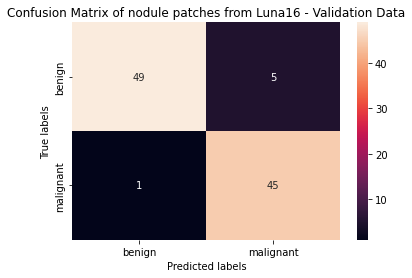

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred_tests).argmax(axis=1), np.asarray(Y_lunas).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of nodule patches from Luna16 - Validation Data'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

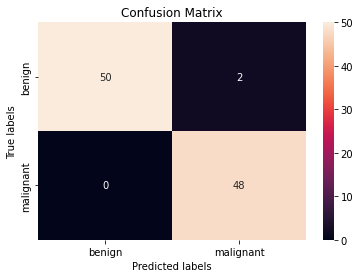

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred_tests).argmax(axis=1), np.asarray(Y_lunas).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

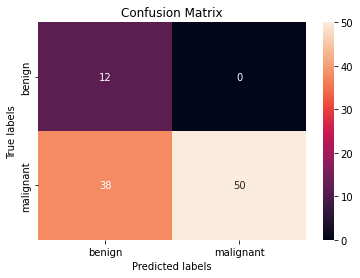

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred_tests).argmax(axis=1), np.asarray(Y_lunas).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

In [ ]:
from sklearn.metrics import roc_curve
p_pred_train = inception_model.predict(X_luna_train)
fpr_train, tpr_train, thresholds_train = roc_curve(np.asarray(y_luna_train).argmax(axis=1), np.asarray(p_pred_train).argmax(axis=1))

In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_train, tpr_train)

In [ ]:
fpr_train = dict()
tpr_train = dict()
roc_auc = dict()
for i in range(2):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_luna_train[:, i], p_pred_train[:, i])
    roc_auc[i] = auc(fpr_train[i], tpr_train[i])

# Compute micro-average ROC curve and ROC area
# fpr_train["micro"], tpr_train["micro"], _ = roc_curve(y_luna_train.ravel(), p_pred_train.ravel())
# roc_auc["micro"] = auc(fpr_train["micro"], tpr_train["micro"])

In [ ]:
from sklearn.metrics import roc_curve
p_pred_test = inception_model.predict(X_luna_test)
fpr_test, tpr_test, thresholds_rf = roc_curve(np.asarray(y_luna_test).argmax(axis=1), np.asarray(p_pred_test).argmax(axis=1))

In [ ]:
from sklearn.metrics import auc
auc_rf = auc(fpr_test, tpr_test)

In [ ]:
fpr_te = dict()
tpr_te = dict()
roc_auc_te = dict()
for i in range(2):
    fpr_te[i], tpr_te[i], _ = roc_curve(y_luna_test[:, i], p_pred_test[:, i])
    roc_auc_te[i] = auc(fpr_te[i], tpr_te[i])

# Compute micro-average ROC curve and ROC area
# fpr_te["micro"], tpr_te["micro"], _ = roc_curve(y_luna_test.ravel(), p_pred_test.ravel())
# roc_auc_te["micro"] = auc(fpr_te["micro"], tpr_te["micro"])

In [ ]:
from sklearn.metrics import roc_curve
p_pred_val = inception_model.predict(X_lunas)
fpr_rff, tpr_rff, thresholds_rf = roc_curve(np.asarray(Y_lunas).argmax(axis=1), np.asarray(p_pred_val).argmax(axis=1))

In [ ]:
from sklearn.metrics import auc
auc_rff = auc(fpr_rff, tpr_rff)

In [ ]:
fpr_va = dict()
tpr_va = dict()
roc_auc_va = dict()
for i in range(2):
    fpr_va[i], tpr_va[i], _ = roc_curve(Y_lunas[:, i], p_pred_val[:, i])
    roc_auc[i] = auc(fpr_va[i], fpr_va[i])

# Compute micro-average ROC curve and ROC area
# fpr_va["micro"], tpr_va["micro"], _ = roc_curve(Y_lunas.ravel(), p_pred_val.ravel())
# roc_auc_va["micro"] = auc(fpr_va["micro"], tpr_va["micro"])

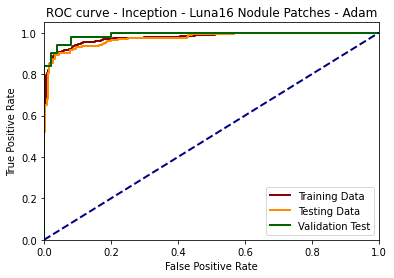

In [ ]:
plt.figure()
lw = 2
plt.plot(
    fpr_train[1],
    tpr_train[1],
    color="darkred",
    lw=lw,
    label="Training Data" ,
)
plt.plot(
    fpr_te[1],
    tpr_te[1],
    color="darkorange",
    lw=lw,
    label="Testing Data",
)
plt.plot(
    fpr_va[0],
    tpr_va[0],
    color="darkgreen",
    lw=lw,
    label="Validation Test",
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve - Inception - Luna16 Nodule Patches - Adam")
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report( np.argmax(y_luna_train, axis=1), np.argmax(y_pred_train, axis=1)))

from sklearn.metrics import classification_report
print(classification_report( np.argmax(y_luna_test, axis=1), np.argmax(p_pred_test, axis=1)))

from sklearn.metrics import classification_report
print(classification_report( np.argmax(Y_lunas, axis=1), np.argmax(p_pred_val, axis=1)))

              precision    recall  f1-score   support

           0       0.85      0.99      0.91       595
           1       0.98      0.83      0.90       595

    accuracy                           0.91      1190
   macro avg       0.92      0.91      0.91      1190
weighted avg       0.92      0.91      0.91      1190

              precision    recall  f1-score   support

           0       0.86      0.98      0.92       255
           1       0.98      0.84      0.90       255

    accuracy                           0.91       510
   macro avg       0.92      0.91      0.91       510
weighted avg       0.92      0.91      0.91       510

              precision    recall  f1-score   support

           0       0.91      0.98      0.94        50
           1       0.98      0.90      0.94        50

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100



In [ ]:
GAN_Noncancer = np.load('/content/drive/My Drive/yazy/noncancer_lung_04Jun/output/generated_noncancer_nodules_2k_96x96.npy')
GAN_Cancer = np.load('/content/drive/MyDrive/yazy/cancer_lung_29May/output/generated_cancer_nodules_2k_96x96.npy')
print(GAN_Cancer.shape,GAN_Noncancer.shape,GAN_Cancer[0].shape,GAN_Noncancer[0].shape)

(2000, 96, 96, 3) (2000, 96, 96, 3) (96, 96, 3) (96, 96, 3)


In [ ]:
GAN_Cancer = GAN_Cancer[:1700]
GAN_Noncancer = GAN_Noncancer[:1700]
print(GAN_Cancer.shape,GAN_Noncancer.shape,GAN_Cancer[0].shape,GAN_Noncancer[0].shape)

(1700, 96, 96, 3) (1700, 96, 96, 3) (96, 96, 3) (96, 96, 3)


In [ ]:
X_GAN = np.concatenate((GAN_Cancer, GAN_Noncancer), axis = 0)
Y_GAN = np.concatenate((np.ones(1700), np.zeros(1700)), axis = 0)
print(X_GAN.shape, Y_GAN.shape)

(3400, 96, 96, 3) (3400,)


In [ ]:
from sklearn.model_selection import train_test_split
(X_GANtrain, X_GANtest, y_GANtrain, y_GANtest) = train_test_split(X_GAN, Y_GAN,test_size=0.3, stratify=Y_GAN, random_state=42)

In [ ]:
print(X_GANtrain.shape, X_GANtest.shape, y_GANtrain.shape, y_GANtest.shape)

(2380, 96, 96, 3) (1020, 96, 96, 3) (2380,) (1020,)


In [ ]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='categorical_crossentropy',#loss='binary_crossentropy', #
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [ ]:
K.clear_session()
gc.collect()

resnet = tf.keras.applications.InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(96,96,3)
)


 
#building RESNET Model

inception_model_GAN = build_model(resnet ,lr = 1e-4)
inception_model_GAN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization_94 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 21,815,074
Trainable params: 21,776,546
No

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
def train_model():
  
  # model = create_model()
  inception_model_GAN.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  logdir = os.path.join("logs", "inception_model_GAN",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  inception_model_GAN.fit(x=X_GANtrain, 
            y=y_GANtrain, 
            epochs=15, 
            validation_data=(X_GANtest, y_GANtest), 
            callbacks=[tensorboard_callback])

train_model()

Epoch 1/15
75/75 [==============================] - 17s 131ms/step - loss: 0.2668 - accuracy: 0.8895 - val_loss: 5.0308 - val_accuracy: 0.3833
Epoch 2/15
75/75 [==============================] - 8s 104ms/step - loss: 0.0214 - accuracy: 0.9950 - val_loss: 0.3338 - val_accuracy: 0.9098
Epoch 3/15
75/75 [==============================] - 8s 104ms/step - loss: 0.0069 - accuracy: 0.9979 - val_loss: 0.0094 - val_accuracy: 0.9990
Epoch 4/15
75/75 [==============================] - 8s 101ms/step - loss: 0.0175 - accuracy: 0.9941 - val_loss: 0.0058 - val_accuracy: 0.9990
Epoch 5/15
75/75 [==============================] - 8s 103ms/step - loss: 0.0112 - accuracy: 0.9966 - val_loss: 0.0263 - val_accuracy: 0.9922
Epoch 6/15
75/75 [==============================] - 8s 104ms/step - loss: 0.0036 - accuracy: 0.9983 - val_loss: 0.0377 - val_accuracy: 0.9873
Epoch 7/15
75/75 [==============================] - 8s 104ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch

In [ ]:
def train_model():
  
  # model = create_model()
  inception_model_GAN.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  logdir = os.path.join("logs", "inception_model_GAN",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  inception_model_GAN.fit(x=X_GANtrain, 
            y=y_GANtrain, 
            epochs=15, 
            validation_data=(X_GANtest, y_GANtest), 
            callbacks=[tensorboard_callback])

train_model()

Epoch 1/15
75/75 [==============================] - 19s 146ms/step - loss: 0.3502 - accuracy: 0.8786 - val_loss: 9.0479 - val_accuracy: 0.5196
Epoch 2/15
75/75 [==============================] - 9s 116ms/step - loss: 0.0401 - accuracy: 0.9857 - val_loss: 0.0943 - val_accuracy: 0.9804
Epoch 3/15
75/75 [==============================] - 9s 115ms/step - loss: 0.0196 - accuracy: 0.9937 - val_loss: 0.0175 - val_accuracy: 0.9941
Epoch 4/15
75/75 [==============================] - 9s 118ms/step - loss: 0.0064 - accuracy: 0.9987 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 5/15
75/75 [==============================] - 9s 117ms/step - loss: 0.0063 - accuracy: 0.9983 - val_loss: 0.0294 - val_accuracy: 0.9853
Epoch 6/15
75/75 [==============================] - 9s 119ms/step - loss: 8.1691e-04 - accuracy: 1.0000 - val_loss: 0.0065 - val_accuracy: 0.9980
Epoch 7/15
75/75 [==============================] - 9s 122ms/step - loss: 6.6982e-04 - accuracy: 1.0000 - val_loss: 0.0032 - val_accuracy: 0.99

In [ ]:
# extract the predicted probabilities
p_pred_GANtrain = inception_model_GAN.predict(X_GANtrain)

In [ ]:
y_pred_GANtrain = np.where(p_pred_GANtrain > 0.5, 1, 0)
print(y_pred_GANtrain)

[[0 1]
 [0 1]
 [0 1]
 ...
 [0 1]
 [1 0]
 [1 0]]


In [ ]:
y_GANtrain = to_categorical(y_GANtrain, num_classes= 2)

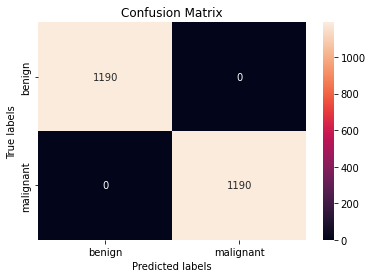

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred_GANtrain).argmax(axis=1), np.asarray(y_GANtrain).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

In [ ]:
# extract the predicted probabilities
p_pred_GANtest = inception_model_GAN.predict(X_GANtest)

In [ ]:
y_pred_GANtest = np.where(p_pred_GANtest > 0.5, 1, 0)
print(y_pred_GANtest)

[[1 0]
 [1 0]
 [0 1]
 ...
 [1 0]
 [1 0]
 [0 1]]


In [ ]:
y_GANtest = to_categorical(y_GANtest, num_classes= 2)

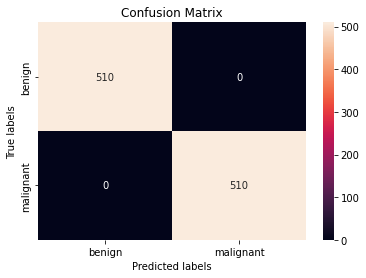

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred_GANtest).argmax(axis=1), np.asarray(y_GANtest).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

In [ ]:
GAN_Noncancer = np.load('/content/drive/My Drive/yazy/noncancer_lung_04Jun/output/generated_noncancer_nodules_2k_96x96.npy')
GAN_Cancer = np.load('/content/drive/MyDrive/yazy/cancer_lung_29May/output/generated_cancer_nodules_2k_96x96.npy')
print(GAN_Cancer.shape,GAN_Noncancer.shape,GAN_Cancer[0].shape,GAN_Noncancer[0].shape)

(2000, 96, 96, 3) (2000, 96, 96, 3) (96, 96, 3) (96, 96, 3)


In [ ]:
testing_GAN_Cancer = GAN_Cancer[1700:]
testing_GAN_Noncancer = GAN_Noncancer[1700:]
print(testing_GAN_Cancer.shape,testing_GAN_Noncancer.shape,testing_GAN_Cancer[0].shape,testing_GAN_Noncancer[0].shape)

(300, 96, 96, 3) (300, 96, 96, 3) (96, 96, 3) (96, 96, 3)


In [ ]:
X_GAN_testing = np.concatenate((testing_GAN_Cancer, testing_GAN_Noncancer), axis = 0)
Y_GAN_testing = np.concatenate((np.ones(300), np.zeros(300)), axis = 0)
print(X_GAN_testing.shape, Y_GAN_testing.shape)

(600, 96, 96, 3) (600,)


In [ ]:
# extract the predicted probabilities
p_predGAN_testing = inception_model_GAN.predict(X_GAN_testing)

In [ ]:
y_pred_GANtesting = np.where(p_predGAN_testing > 0.5, 1, 0)
print(y_pred_GANtesting)

[[0 1]
 [0 1]
 [0 1]
 ...
 [1 0]
 [1 0]
 [1 0]]


In [ ]:
Y_GAN_testing = to_categorical(Y_GAN_testing, num_classes= 2)

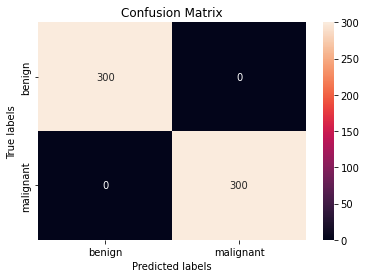

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred_GANtesting).argmax(axis=1), np.asarray(Y_GAN_testing).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

In [ ]:
from sklearn.metrics import roc_curve
p_GAN_train = inception_model_GAN.predict(X_GANtrain)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(np.asarray(y_GANtrain).argmax(axis=1), np.asarray(p_GAN_train).argmax(axis=1))

In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [ ]:
fpr_GANtrain = dict()
tpr_GANtrain = dict()
roc_GANtrainauc = dict()
for i in range(2):
    fpr_GANtrain[i], tpr_GANtrain[i], _ = roc_curve(y_GANtrain[:, i], p_GAN_train[:, i])
    roc_GANtrainauc[i] = auc(fpr_GANtrain[i], tpr_GANtrain[i])

# Compute micro-average ROC curve and ROC area
# fpr_GANtrain["micro"], tpr_GANtrain["micro"], _ = roc_curve(y_GANtrain.ravel(), p_GAN_train.ravel())
# roc_GANtrainauc["micro"] = auc(fpr_GANtrain["micro"], tpr_GANtrain["micro"])

In [ ]:
from sklearn.metrics import roc_curve
p_GAN_test = inception_model_GAN.predict(X_GANtest)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(np.asarray(y_GANtest).argmax(axis=1), np.asarray(p_GAN_test).argmax(axis=1))

In [ ]:
from sklearn.metrics import auc
auc_rf = auc(fpr_rf, tpr_rf)

In [ ]:
fpr_GANtest = dict()
tpr_GANtest = dict()
roc_GANtestauc = dict()
for i in range(2):
    fpr_GANtest[i], tpr_GANtest[i], _ = roc_curve(y_GANtest[:, i], p_GAN_test[:, i])
    roc_GANtestauc[i] = auc(fpr_GANtest[i], tpr_GANtest[i])

# Compute micro-average ROC curve and ROC area
# fpr_GANtest["micro"], tpr_GANtest["micro"], _ = roc_curve(y_GANtest.ravel(), p_GAN_test.ravel())
# roc_GANtestauc["micro"] = auc(fpr_GANtest["micro"], tpr_GANtest["micro"])

In [ ]:
from sklearn.metrics import roc_curve
p_GAN_testing = inception_model_GAN.predict(X_GAN_testing)
fpr_rff, tpr_rff, thresholds_rf = roc_curve(np.asarray(Y_GAN_testing).argmax(axis=1), np.asarray(p_GAN_testing).argmax(axis=1))

In [ ]:
from sklearn.metrics import auc
auc_rff = auc(fpr_rff, tpr_rff)

In [ ]:
fpr_GANtesting = dict()
tpr_GANtesting = dict()
roc_GANtestauc = dict()
for i in range(2):
    fpr_GANtesting[i], tpr_GANtesting[i], _ = roc_curve(Y_GAN_testing[:, i], p_GAN_testing[:, i])
    roc_GANtestauc[i] = auc(fpr_GANtesting[i], tpr_GANtesting[i])

# Compute micro-average ROC curve and ROC area
# fpr_GANtesting["micro"], tpr_GANtesting["micro"], _ = roc_curve(y_GANtest.ravel(), p_GAN_test.ravel())
# roc_GANtestauc["micro"] = auc(fpr_GANtesting["micro"], tpr_GANtesting["micro"])

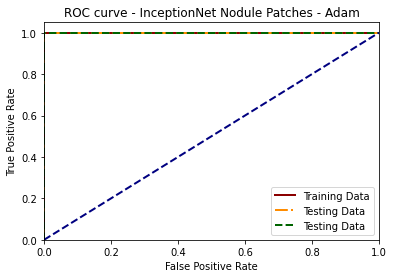

In [ ]:
plt.figure()
lw = 2
plt.plot(
    fpr_GANtrain[1],
    tpr_GANtrain[1],
    color="darkred",
    lw=lw,
    label="Training Data" ,
)
plt.plot(
    fpr_GANtest[1],
    tpr_GANtest[1],
    color="darkorange",
    lw=lw,
    label="Testing Data",
    linestyle="dashdot",
)
plt.plot(
    fpr_GANtesting[1],
    tpr_GANtesting[1],
    color="darkgreen",
    lw=lw,
    label="Testing Data",
    linestyle="--",
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve - InceptionNet Nodule Patches - Adam")
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report( np.argmax(y_GANtrain, axis=1), np.argmax(p_pred_GANtrain, axis=1)))

from sklearn.metrics import classification_report
print(classification_report( np.argmax(y_GANtest, axis=1), np.argmax(p_GAN_test, axis=1)))

from sklearn.metrics import classification_report
print(classification_report( np.argmax(Y_GAN_testing, axis=1), np.argmax(p_GAN_testing, axis=1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1190
           1       1.00      1.00      1.00      1190

    accuracy                           1.00      2380
   macro avg       1.00      1.00      1.00      2380
weighted avg       1.00      1.00      1.00      2380

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       510
           1       1.00      1.00      1.00       510

    accuracy                           1.00      1020
   macro avg       1.00      1.00      1.00      1020
weighted avg       1.00      1.00      1.00      1020

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      1.00      1.00       300

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



In [ ]:
!tensorboard dev upload --logdir logs


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=8jnPdDmYekmM8wOTiEFbWNFWQ0sRbo&prompt=consent&access_type=offline
Enter th

In [ ]:
y_GANtrain = to_categorical(y_GANtrain, num_classes= 2)

In [ ]:
from sklearn.metrics import roc_curve
y_pred_GAN = inception_model.predict(X_GANtrain)
fpr_GAN, tpr_GAN, thresholds_GAN = roc_curve(np.asarray(y_GANtrain).argmax(axis=1), np.asarray(y_pred_GAN).argmax(axis=1))

In [ ]:
from sklearn.metrics import auc
auc_GAN = auc(fpr_GAN, tpr_GAN)

In [ ]:
y_GANtest = to_categorical(y_GANtest, num_classes= 2)

In [ ]:
from sklearn.metrics import roc_curve
y_test_GAN = inception_model.predict(X_GANtest)
fprtest_GAN, tprtest_GAN, thresholdstest_GAN = roc_curve(np.asarray(y_GANtest).argmax(axis=1), np.asarray(y_test_GAN).argmax(axis=1))

In [ ]:
from sklearn.metrics import auc
auctest_GAN = auc(fprtest_GAN, tprtest_GAN)

In [ ]:
Y_GAN_testing = to_categorical(Y_GAN_testing, num_classes= 2)

In [ ]:
from sklearn.metrics import roc_curve
y_testing_GAN = inception_model.predict(X_GAN_testing)
fpr_GAN_testing, tpr_GAN_testing, thresholds_GAN_testing = roc_curve(np.asarray(Y_GAN_testing).argmax(axis=1), np.asarray(y_testing_GAN).argmax(axis=1))

ValueError: ignored

In [ ]:
from sklearn.metrics import auc
auc_GAN_testing = auc(fpr_GAN_testing, tpr_GAN_testing)

NameError: ignored

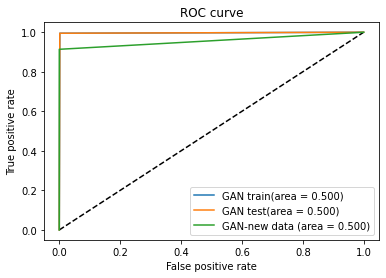

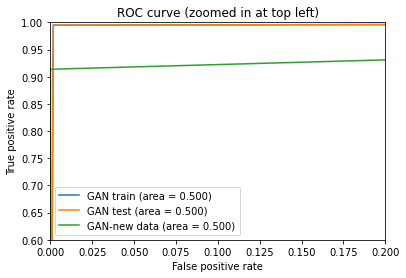

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='GAN train(area = {:.3f})'.format(auc_GAN))
plt.plot(fpr_keras, tpr_keras, label='GAN test(area = {:.3f})'.format(auctest_GAN))
plt.plot(fpr_rf, tpr_rf, label='GAN-new data (area = {:.3f})'.format(auc_GAN_testing))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0,0.2)
plt.ylim(0.6,1.0)
plt.plot([0, 2], [0, 2], 'k--')
plt.plot(fpr_keras, tpr_keras, label='GAN train (area = {:.3f})'.format(auc_GAN))
plt.plot(fpr_keras, tpr_keras, label='GAN test (area = {:.3f})'.format(auctest_GAN))
plt.plot(fpr_rf, tpr_rf, label='GAN-new data (area = {:.3f})'.format(auc_GAN_testing))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [ ]:
!tensorboard dev upload --logdir logs


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=4t6gDy7YqkV8uG4FsaeTj85aOvByAl&prompt=consent&access_type=offline
Enter th

In [ ]:
GAN_Noncancer = np.load('/content/drive/My Drive/yazy/noncancer_lung_04Jun/output/generated_noncancer_nodules_2k_96x96.npy')
GAN_Cancer = np.load('/content/drive/MyDrive/yazy/cancer_lung_29May/output/generated_cancer_nodules_2k_96x96.npy')
print(GAN_Cancer.shape,GAN_Noncancer.shape,GAN_Cancer[0].shape,GAN_Noncancer[0].shape)

(2000, 96, 96, 3) (2000, 96, 96, 3) (96, 96, 3) (96, 96, 3)


In [ ]:
test_GAN_non_cancer_data = GAN_Noncancer[1800:2000]
test_GAN_cancer_data = GAN_Cancer[1800:2000]
print(test_GAN_non_cancer_data.shape,test_GAN_cancer_data.shape,test_GAN_non_cancer_data[0].shape,test_GAN_cancer_data[0].shape)

(200, 96, 96, 3) (200, 96, 96, 3) (96, 96, 3) (96, 96, 3)


In [ ]:
X_GAN_testing = np.concatenate((test_GAN_non_cancer_data,test_GAN_cancer_data), axis = 0)
print(X_GAN_testing.shape, X_GAN_testing[0].shape)

(400, 96, 96, 3) (96, 96, 3)


In [ ]:
GANcancer_labels = np.ones(200)
GANnoncancer_labels = np.zeros(200)
Y_GAN_testing = np.concatenate((GANnoncancer_labels,GANcancer_labels), axis = 0)
print(X_GAN_testing.shape, Y_GAN_testing.shape)

(400, 96, 96, 3) (400,)


In [ ]:
Y_GAN_testing = to_categorical(Y_GAN_testing, num_classes= 2)
print(Y_GAN_testing.shape)

(400, 2)


In [ ]:
y_test = to_categorical(y_test, num_classes= 2)
print(y_test.shape)

(1020, 2)


In [ ]:
# extract the predicted probabilities
p_pred = inception_model.predict(X_GAN_testing)

In [ ]:
y_pred = np.where(p_pred > 0.5, 1, 0)
print(y_pred)

[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]

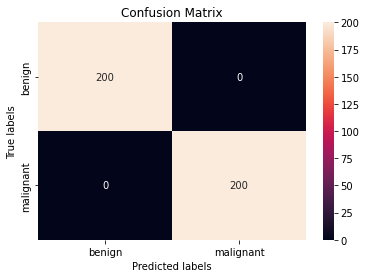

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred).argmax(axis=1), np.asarray(Y_GAN_testing).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

In [ ]:
from sklearn.metrics import roc_curve
y_pred_keras = inception_model.predict(X_GAN_testing).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(np.asarray(Y_GAN_testing).argmax(axis=1), np.asarray(y_pred).argmax(axis=1))

In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [ ]:
# extract the predicted probabilities
p_pred = inception_model.predict(X_luna_test)

In [ ]:
y_pred = np.where(p_pred > 0.5, 1, 0)
print(y_pred)

[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]

In [ ]:
X_luna_test.shape

(480, 96, 96, 3)

In [ ]:
from sklearn.metrics import roc_curve
y_pred_keras = inception_model.predict(X_luna_test).ravel()
fpr_rf, tpr_rf, thresholds_rf = roc_curve(np.asarray(y_luna_test).argmax(axis=1), np.asarray(y_pred).argmax(axis=1))
auc_rf = auc(fpr_rf, tpr_rf)

In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

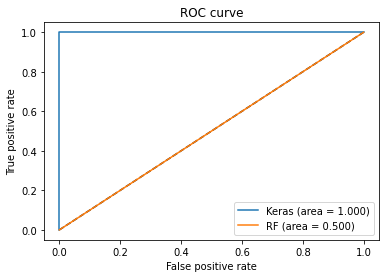

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

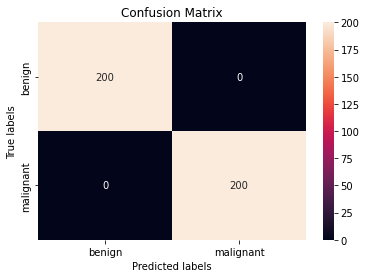

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred).argmax(axis=1), np.asarray(Y_GAN_testing).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

In [ ]:
lunas_cancer_data = np.load('/content/drive/MyDrive/Ramasubramanya/LotusFeet/cancernodule_image_900_96_96_patches.npy')
lunas_cancer_data = lunas_cancer_data[800:]
print(lunas_cancer_data.shape, lunas_cancer_data[0].shape)

(900, 96, 96, 1) (96, 96, 1)


In [ ]:
lunas_cancer_data = lunas_cancer_data.reshape(100,96,96)
lunas_cancer_data_rgb = np.repeat(lunas_cancer_data[..., np.newaxis], 3, -1)
print(lunas_cancer_data_rgb.shape, lunas_cancer_data_rgb[0].shape)

(100, 96, 96, 3) (96, 96, 3)


In [ ]:
lunas_non_cancer_data = np.load("/content/drive/MyDrive/Ramasubramanya/LotusFeet/non_cancernodule_image_1400_96_96_patches.npy")
lunas_non_cancer_data = lunas_non_cancer_data[800:900]
print(lunas_non_cancer_data.shape, lunas_non_cancer_data[0].shape)

(100, 96, 96, 1) (96, 96, 1)


In [ ]:
lunas_non_cancer_data = lunas_non_cancer_data.reshape(100,96,96)
lunas_non_cancer_data_rgb = np.repeat(lunas_non_cancer_data[..., np.newaxis], 3, -1)
print(lunas_non_cancer_data_rgb.shape, lunas_non_cancer_data_rgb[0].shape)

(100, 96, 96, 3) (96, 96, 3)


In [ ]:
X_luna = np.concatenate((lunas_cancer_data_rgb,lunas_non_cancer_data_rgb), axis = 0)
print(X_luna.shape, X_luna[0].shape)

(200, 96, 96, 3) (96, 96, 3)


In [ ]:
cancer_labels = np.ones(100)
noncancer_labels = np.zeros(100)
Y_luna = np.concatenate((cancer_labels,noncancer_labels), axis = 0)

print(X_luna.shape, Y_luna.shape)


(200, 96, 96, 3) (200,)


In [ ]:
from sklearn.model_selection import train_test_split
(X_lunas_train, X_lunas_test, y_lunas_train, y_lunas_test) = train_test_split(X_luna, Y_luna,test_size=0.3, stratify=Y_luna, random_state=42)

In [ ]:
print(X_lunas_train.shape, X_lunas_test.shape, y_lunas_train.shape, y_lunas_test.shape)

(140, 96, 96, 3) (60, 96, 96, 3) (140,) (60,)


In [ ]:
# extract the predicted probabilities
p_pred = inception_model.predict(X_luna)

In [ ]:
y_pred = np.where(p_pred > 0.5, 1, 0)
print(y_pred)

[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]

In [ ]:
Y_luna = to_categorical(Y_luna, num_classes= 2)

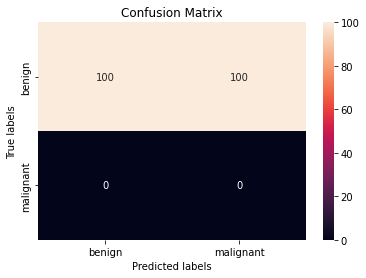

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred).argmax(axis=1), np.asarray(Y_luna).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

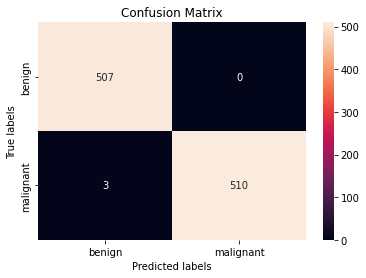

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred).argmax(axis=1), np.asarray(y_test).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

In [ ]:
# extract the predicted probabilities
p_pred = inception_model.predict(X_GAN_testing)

In [ ]:
y_pred = np.where(p_pred > 0.5, 1, 0)
print(y_pred)

[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]

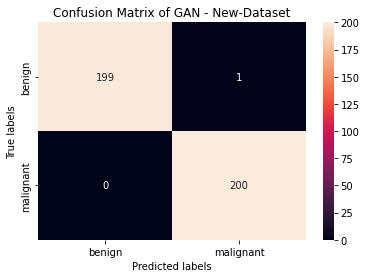

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(Y_GAN_testing).argmax(axis=1), np.asarray(y_pred).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of GAN - New-Dataset'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);


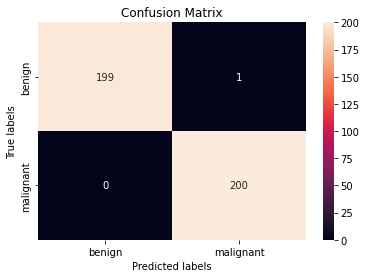

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(Y_GAN_testing).argmax(axis=1), np.asarray(y_pred).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);


In [ ]:
luna_cancer_datas = np.load('/content/drive/MyDrive/Ramasubramanya/LotusFeet/cancernodule_image_900_96_96_patches.npy')
print(luna_cancer_datas.shape, luna_cancer_datas[0].shape)

(900, 96, 96, 1) (96, 96, 1)


In [ ]:
luna_cancer_datas = luna_cancer_datas[800:]
print(luna_cancer_datas.shape, luna_cancer_datas[0].shape)

(100, 96, 96, 1) (96, 96, 1)


In [ ]:
luna_cancer_datas = luna_cancer_datas.reshape(100,96,96)
luna_cancer_datas_rgb = np.repeat(luna_cancer_datas[..., np.newaxis], 3, -1)
print(luna_cancer_datas_rgb.shape, luna_cancer_datas_rgb[0].shape)

(100, 96, 96, 3) (96, 96, 3)


In [ ]:
luna_non_cancer_datas = np.load("/content/drive/MyDrive/Ramasubramanya/LotusFeet/non_cancernodule_image_1400_96_96_patches.npy")
print(luna_non_cancer_datas.shape, luna_non_cancer_datas[0].shape)

(1400, 96, 96, 1) (96, 96, 1)


In [ ]:
luna_non_cancer_datas = luna_non_cancer_datas[800:900]
print(luna_non_cancer_datas.shape, luna_non_cancer_datas[0].shape)

(100, 96, 96, 1) (96, 96, 1)


In [ ]:
luna_non_cancer_datas = luna_non_cancer_datas.reshape(100,96,96)
luna_non_cancer_datas_rgb = np.repeat(luna_non_cancer_datas[..., np.newaxis], 3, -1)
print(luna_non_cancer_datas_rgb.shape, luna_non_cancer_datas_rgb[0].shape)

(100, 96, 96, 3) (96, 96, 3)


In [ ]:
X_lunas = np.concatenate((luna_cancer_datas_rgb,luna_non_cancer_datas_rgb), axis = 0)
print(X_lunas.shape, X_lunas[0].shape)

(200, 96, 96, 3) (96, 96, 3)


In [ ]:
lunas_cancer_data_labels = np.ones(100)
lunas_non_cancer_data_labels = np.zeros(100)
Y_lunas = np.concatenate((lunas_cancer_data_labels,lunas_non_cancer_data_labels), axis = 0)
print(Y_lunas.shape)

(200,)


In [ ]:
# To categorical
Y_lunas = to_categorical(Y_lunas, num_classes= 2)
print(Y_lunas.shape)

(200, 2)


In [ ]:
from sklearn.model_selection import train_test_split
(X_lunas_train, X_lunas_test, y_lunas_train, y_lunas_test) = train_test_split(X_lunas, Y_lunas,test_size=0.3, stratify=Y_lunas, random_state=42)

In [ ]:
print(X_lunas_train.shape, X_lunas_test.shape, y_lunas_train.shape, y_lunas_test.shape)

(140, 96, 96, 3) (60, 96, 96, 3) (140,) (60,)


In [ ]:
def train_model():
  
  # model = create_model()
  inception_model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  logdir = os.path.join("logs", "inception_model",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  inception_model.fit(x=X_lunas_train, 
            y=y_lunas_train, 
            epochs=10, 
            validation_data=(X_lunas_test, y_lunas_test), 
            callbacks=[tensorboard_callback])

train_model()

Epoch 1/10
5/5 [==============================] - 14s 1s/step - loss: 1.2573 - accuracy: 0.8071 - val_loss: 3.9572 - val_accuracy: 0.5000
Epoch 2/10
5/5 [==============================] - 4s 1s/step - loss: 0.3665 - accuracy: 0.8143 - val_loss: 102.0470 - val_accuracy: 0.5000
Epoch 3/10
5/5 [==============================] - 4s 1s/step - loss: 0.3416 - accuracy: 0.8500 - val_loss: 5.5247 - val_accuracy: 0.5000
Epoch 4/10
5/5 [==============================] - 4s 1s/step - loss: 0.2411 - accuracy: 0.8929 - val_loss: 3.6018 - val_accuracy: 0.5000
Epoch 5/10
5/5 [==============================] - 4s 1s/step - loss: 0.1631 - accuracy: 0.9286 - val_loss: 1.4797 - val_accuracy: 0.5000
Epoch 6/10
5/5 [==============================] - 4s 1s/step - loss: 0.1142 - accuracy: 0.9714 - val_loss: 1.0639 - val_accuracy: 0.5000
Epoch 7/10
5/5 [==============================] - 4s 1s/step - loss: 0.1443 - accuracy: 0.9571 - val_loss: 0.8660 - val_accuracy: 0.5000
Epoch 8/10
5/5 [======================

In [ ]:
# To categorical
y_lunas_train = to_categorical(y_lunas_train, num_classes= 2)
y_lunas_test = to_categorical(y_lunas_test, num_classes= 2)

In [ ]:
# extract the predicted probabilities
p_pred = inception_model.predict(X_lunas_train)

In [ ]:
y_pred = np.where(p_pred > 0.5, 1, 0)
print(y_pred)

[[0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]]


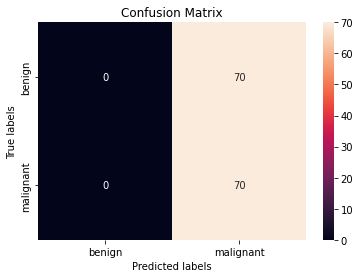

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_lunas_train).argmax(axis=1), np.asarray(y_pred).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

In [ ]:
from sklearn.metrics import roc_curve
y_pred_GAN = inception_model.predict(X_GANtrain)
fpr_GAN, tpr_GAN, thresholds_GAN = roc_curve(np.asarray(y_GANtrain).argmax(axis=1), np.asarray(y_pred_GAN).argmax(axis=1))

AxisError: ignored

In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
